In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.models.segmentation import fcn_resnet50
from torchvision.datasets import VOCSegmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score
import seaborn as sns

In [13]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.transform = A.Compose([
            A.Resize(128, 128),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, mask = self.subset[idx]
        image = np.array(image)
        mask = np.array(mask)

        augmented = self.transform(image=image, mask=mask)
        return augmented["image"], augmented["mask"].long()

In [ ]:
# Location of main dataset
base_dir  = '/kaggle/input/dl-2025-competition-1/data'

# Show main directory containers
os.listdir(base_dir)

In [ ]:
# Define train and test folders pathes.
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
classes = os.listdir(train_dir)
num_classes = len(classes)
print(num_classes)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =.to(device)
data = data.to(device)

SyntaxError: invalid syntax (3284425267.py, line 2)

In [23]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

   
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        
        if os.path.isdir(subdir_path):
          
            image_files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            num_images = len(image_files)
            print(f"{subdir}: {num_images}")
            total_images += num_images

           
            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    
    print("\nUnique resolutions:")
    for size in unique_sizes:
      
    print("---------------")

    print(f"\nTotal images: {total_images}")


train_dir = '/kaggle/input/dl-2025-competition-1/data/train'
print_images_resolution(train_dir)

7: 137
47: 61
17: 140
81: 48
19: 87
22: 115
2: 143
35: 72
92: 106
50: 55
23: 32
87: 106
10: 134
5: 45
61: 80
36: 118
20: 138
45: 133
60: 37
27: 128
64: 144
41: 149
89: 96
39: 104
32: 88
98: 112
25: 70
42: 108
52: 127
75: 63
8: 45
38: 125
12: 117
94: 110
55: 76
49: 108
0: 110
31: 78
62: 79
53: 56
70: 38
34: 118
18: 47
79: 88
85: 150
88: 107
65: 69
67: 52
78: 75
28: 149
66: 111
56: 139
72: 99
16: 125
13: 109
99: 72
26: 44
74: 138
15: 137
3: 119
90: 34
69: 44
77: 44
86: 71
95: 101
43: 34
91: 147
71: 48
1: 109
58: 80
59: 146


KeyboardInterrupt: 

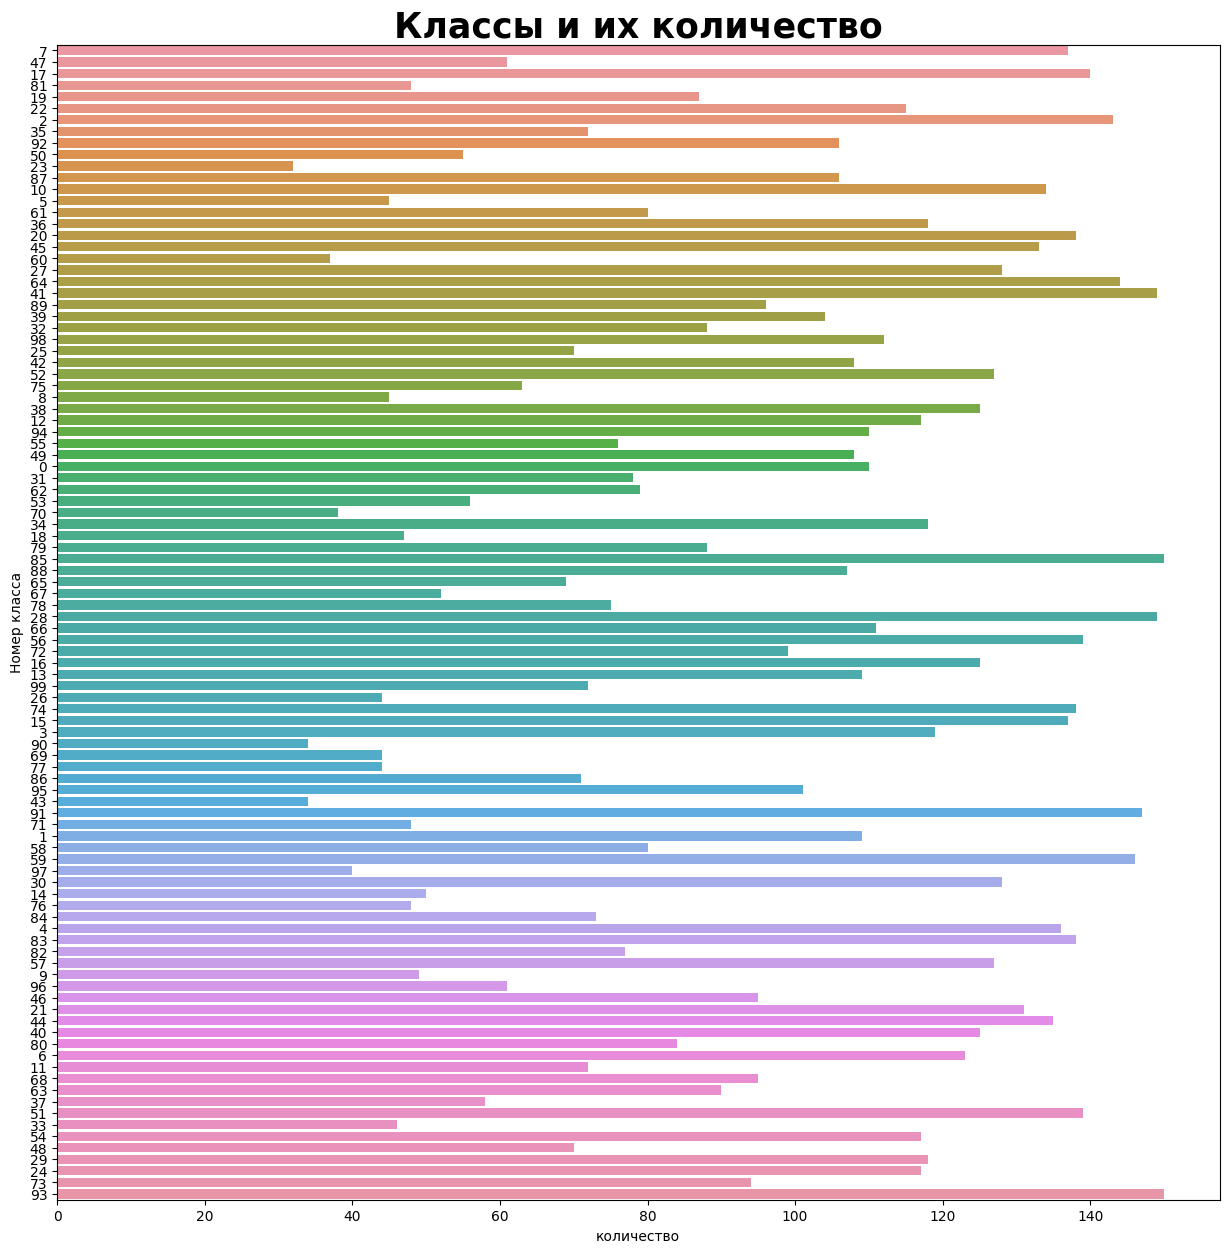

In [26]:

counts = []


for class_name in classes :
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    counts.append((class_name, count))

counts = pd.DataFrame(counts, columns=['Номер класса', 'количество'])


plt.figure(figsize=(15, 15))
ax = sns.barplot(data=counts, y='Номер класса', x='количество')
ax.set_title('Классы и их количество', fontsize=25, fontweight='bold')

plt.show()

видим дисбаланс классов, нужно будет учесть это при разделении тренировочного набора

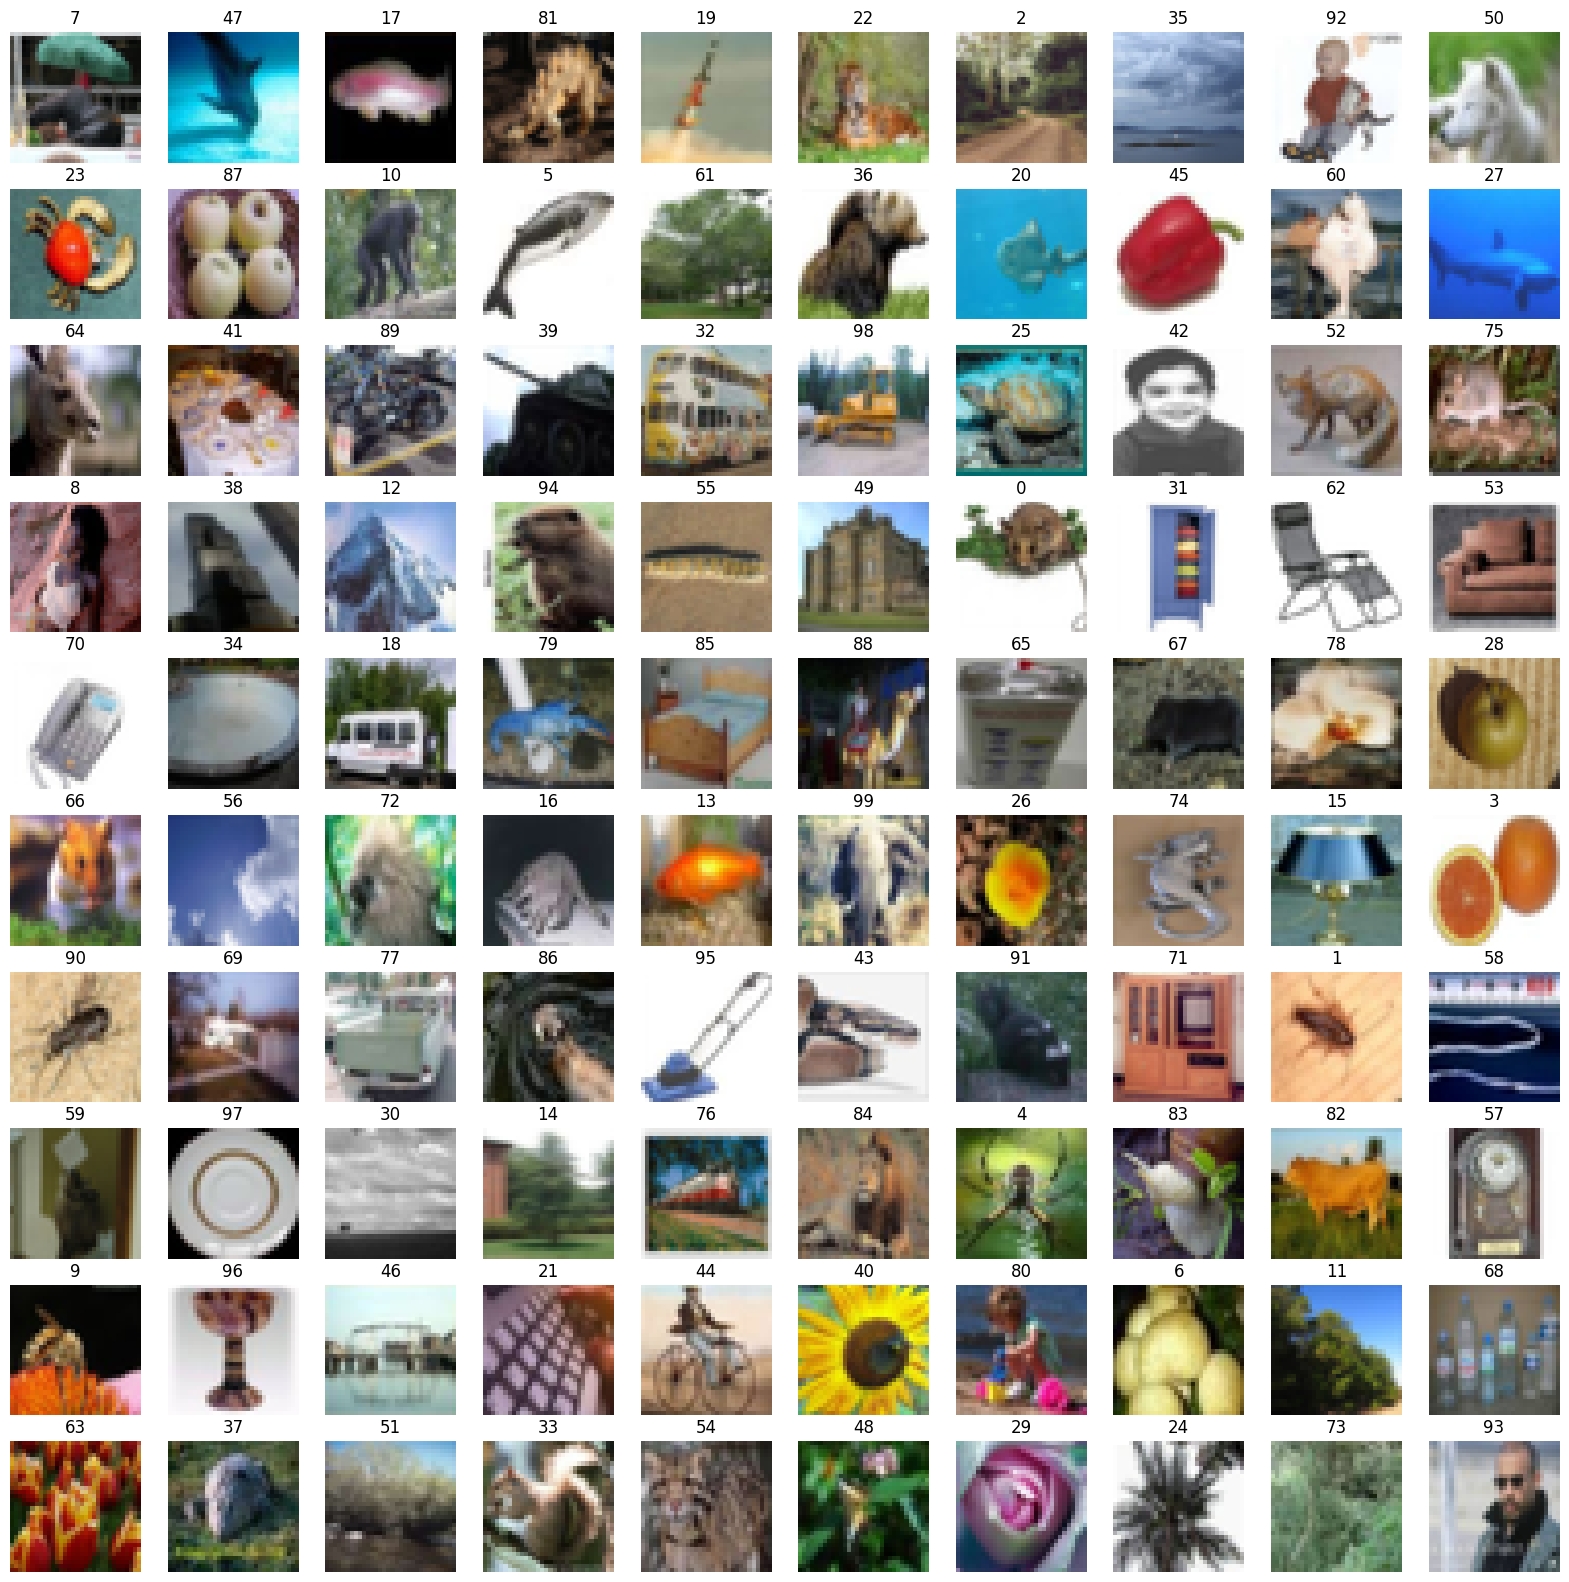

In [30]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))


for i in range(100) :    
    class_name = classes[i]
    class_path = os.path.join(train_dir, class_name)
    img = [file for file in os.listdir(class_path) if file.endswith('.png')]
    img = os.path.join(class_path, img[0])
    img = Image.open(img)
    
    
    col = i // 10
    row = i % 10

    ax[col, row].imshow(img)
    ax[col, row].axis('off')
    ax[col, row].set_title(class_name)
plt.show()

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None, augmentations=None):
        self.image_folder = image_folder
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        if isinstance(image, Image.Image):
            image = np.array(image)
        if self.augmentations:
            
            image = np.array(image) 
            image = self.augmentations(image=image)["image"]
        if isinstance(image, np.ndarray):
            if image.dtype == np.float32 or image.dtype == np.float64:
                image = (image * 255).astype(np.uint8)
        
        image = Image.fromarray(image)

                                         
        if self.transform:
            image = self.transform(image)
        return image, label

Epoch [1/20], Loss: 4.5421, Accuracy: 0.0222, Val Loss: 4.6762, Val Accuracy: 0.0289
Epoch [2/20], Loss: 4.3826, Accuracy: 0.0285, Val Loss: 4.9247, Val Accuracy: 0.0216
Epoch [3/20], Loss: 4.3260, Accuracy: 0.0342, Val Loss: 5.0947, Val Accuracy: 0.0247
Epoch [4/20], Loss: 4.3044, Accuracy: 0.0415, Val Loss: 4.4282, Val Accuracy: 0.0410
Epoch [5/20], Loss: 4.2420, Accuracy: 0.0472, Val Loss: 4.4529, Val Accuracy: 0.0358
Epoch [6/20], Loss: 4.1774, Accuracy: 0.0581, Val Loss: 4.3190, Val Accuracy: 0.0510
Epoch [7/20], Loss: 4.1115, Accuracy: 0.0647, Val Loss: 4.1844, Val Accuracy: 0.0668
Epoch [8/20], Loss: 4.0359, Accuracy: 0.0743, Val Loss: 5.0995, Val Accuracy: 0.0421
Epoch [9/20], Loss: 3.9733, Accuracy: 0.0823, Val Loss: 4.1711, Val Accuracy: 0.0615
Epoch [10/20], Loss: 3.8828, Accuracy: 0.0946, Val Loss: 4.8663, Val Accuracy: 0.0405
Epoch [11/20], Loss: 3.8257, Accuracy: 0.1032, Val Loss: 5.0952, Val Accuracy: 0.0610
Epoch [12/20], Loss: 3.8122, Accuracy: 0.1071, Val Loss: 4.2294

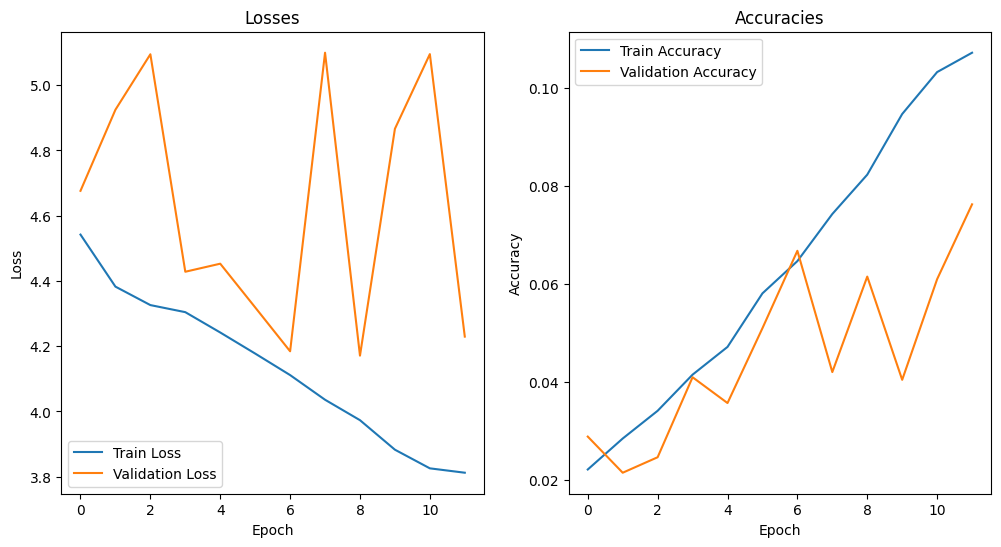

Лучшее состояние модели сохранено.


In [14]:
import albumentations as A
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


data_dir = '/kaggle/input/dl-2025-competition-1/data/train' 

augmentation_pipeline_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
])

augmentation_pipeline_val = A.Compose([
    A.Normalize(),
])

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None, augmentations=None):
        self.image_folder = image_folder
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        if isinstance(image, Image.Image):
            image = np.array(image)
        if self.augmentations:
         
            image = np.array(image)  
            image = self.augmentations(image=image)["image"]
        if isinstance(image, np.ndarray):
            if image.dtype == np.float32 or image.dtype == np.float64:
                image = (image * 255).astype(np.uint8)
        
        image = Image.fromarray(image)

                                         
        if self.transform:
            image = self.transform(image)
        return image, label


transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),            
])


full_dataset = datasets.ImageFolder(root=data_dir)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(CustomImageDataset(train_dataset, transform=transform, augmentations=augmentation_pipeline_train), 
                          batch_size=32, shuffle=True,num_workers=4)
val_loader = DataLoader(CustomImageDataset(val_dataset, transform=transform, augmentations=augmentation_pipeline_val), 
                        batch_size=32, shuffle=False,num_workers=4)


model = torchvision.models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_dataset.classes))  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 20  
best_val_loss = float('inf')
early_stopping_counter = 0
patience = 3
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

      
        optimizer.zero_grad()

      
        outputs = model(inputs)
        loss = criterion(outputs, labels)

       
        loss.backward()
        optimizer.step()

   
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)


    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_accuracy = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    # Ранняя остановка
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print("Лучшее состояние модели сохранено.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Epoch [1/30], Loss: 4.5562, Accuracy: 0.0323, Val Loss: 4.3591, Val Accuracy: 0.0478
Epoch [2/30], Loss: 4.2703, Accuracy: 0.0535, Val Loss: 4.2257, Val Accuracy: 0.0589
Epoch [3/30], Loss: 4.0982, Accuracy: 0.0785, Val Loss: 4.2055, Val Accuracy: 0.0799
Epoch [4/30], Loss: 3.9332, Accuracy: 0.0889, Val Loss: 4.0771, Val Accuracy: 0.0994
Epoch [5/30], Loss: 3.8174, Accuracy: 0.1088, Val Loss: 3.7795, Val Accuracy: 0.1183
Epoch [6/30], Loss: 3.5133, Accuracy: 0.1580, Val Loss: 3.4001, Val Accuracy: 0.1972
Epoch [7/30], Loss: 3.3741, Accuracy: 0.1868, Val Loss: 3.3220, Val Accuracy: 0.2040
Epoch [8/30], Loss: 3.3209, Accuracy: 0.1889, Val Loss: 3.2729, Val Accuracy: 0.2208
Epoch [9/30], Loss: 3.2608, Accuracy: 0.2082, Val Loss: 3.2504, Val Accuracy: 0.2229
Epoch [10/30], Loss: 3.2058, Accuracy: 0.2083, Val Loss: 3.2392, Val Accuracy: 0.2324
Epoch [11/30], Loss: 3.1338, Accuracy: 0.2273, Val Loss: 3.2111, Val Accuracy: 0.2350
Epoch [12/30], Loss: 3.1093, Accuracy: 0.2325, Val Loss: 3.1896

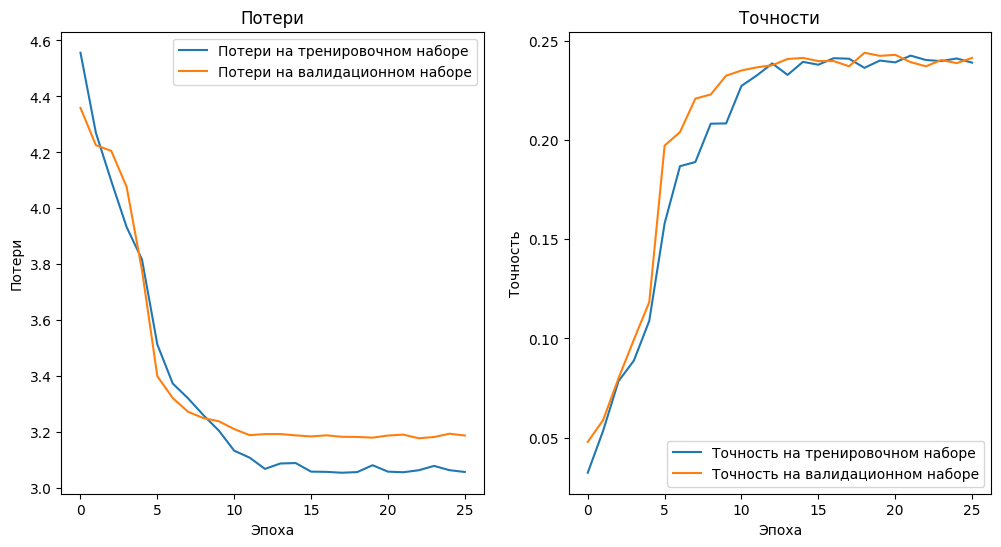

Лучшая модель сохранена.


In [3]:

import albumentations as A
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image  


data_directory = '/kaggle/input/dl-2025-competition-1/data/train' 


train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(width=32, height=32, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(),
])

val_augmentation = A.Compose([
    A.Normalize(),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, augmentations=None):
        self.dataset = dataset
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if isinstance(image, Image.Image):
            image = np.array(image)
        if self.augmentations:
            image = self.augmentations(image=image)["image"]
        if isinstance(image, np.ndarray):
            if image.dtype == np.float32 or image.dtype == np.float64:
                image = (image * 255).astype(np.uint8)
        
        image = Image.fromarray(image)
                                         
        if self.transform:
            image = self.transform(image)
        return image, label


image_transformations = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=data_directory)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(CustomDataset(train_dataset, transform=image_transformations, augmentations=train_augmentation), 
                          batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(CustomDataset(val_dataset, transform=image_transformations, augmentations=val_augmentation), 
                        batch_size=32, shuffle=False, num_workers=4)


model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_dataset.classes))  # Подстраиваем под количество классов


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 30  
best_loss = float('inf')
early_stopping_counter = 0
patience = 3
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

      
        optimizer.zero_grad()

       
        predictions = model(inputs)
        loss = loss_function(predictions, labels)

        
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, predicted = torch.max(predictions.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)


    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = loss_function(predictions, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_accuracy = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Ранняя остановка активирована.")
            break

    
    scheduler.step()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Потери на тренировочном наборе')
plt.plot(val_losses, label='Потери на валидационном наборе')
plt.title('Потери')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Точность на тренировочном наборе')
plt.plot(val_accuracies, label='Точность на валидационном наборе')
plt.title('Точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.show()

print("Лучшая модель сохранена.")

Epoch [1/30], Loss: 4.7119, Accuracy: 0.0143, Val Loss: 4.5909, Val Accuracy: 0.0300
Epoch [2/30], Loss: 4.5599, Accuracy: 0.0241, Val Loss: 4.5783, Val Accuracy: 0.0289
Epoch [3/30], Loss: 4.4802, Accuracy: 0.0305, Val Loss: 4.4056, Val Accuracy: 0.0326
Epoch [4/30], Loss: 4.3528, Accuracy: 0.0398, Val Loss: 4.3861, Val Accuracy: 0.0410
Epoch [5/30], Loss: 4.2331, Accuracy: 0.0561, Val Loss: 4.1412, Val Accuracy: 0.0731
Epoch [6/30], Loss: 4.0059, Accuracy: 0.0860, Val Loss: 3.8944, Val Accuracy: 0.1030
Epoch [7/30], Loss: 3.9012, Accuracy: 0.0998, Val Loss: 3.8318, Val Accuracy: 0.1046
Epoch [8/30], Loss: 3.8524, Accuracy: 0.1024, Val Loss: 3.7926, Val Accuracy: 0.1172
Epoch [9/30], Loss: 3.7837, Accuracy: 0.1157, Val Loss: 3.6880, Val Accuracy: 0.1351
Epoch [10/30], Loss: 3.7192, Accuracy: 0.1176, Val Loss: 3.6578, Val Accuracy: 0.1309
Epoch [11/30], Loss: 3.6326, Accuracy: 0.1358, Val Loss: 3.6009, Val Accuracy: 0.1467
Epoch [12/30], Loss: 3.6008, Accuracy: 0.1396, Val Loss: 3.5804

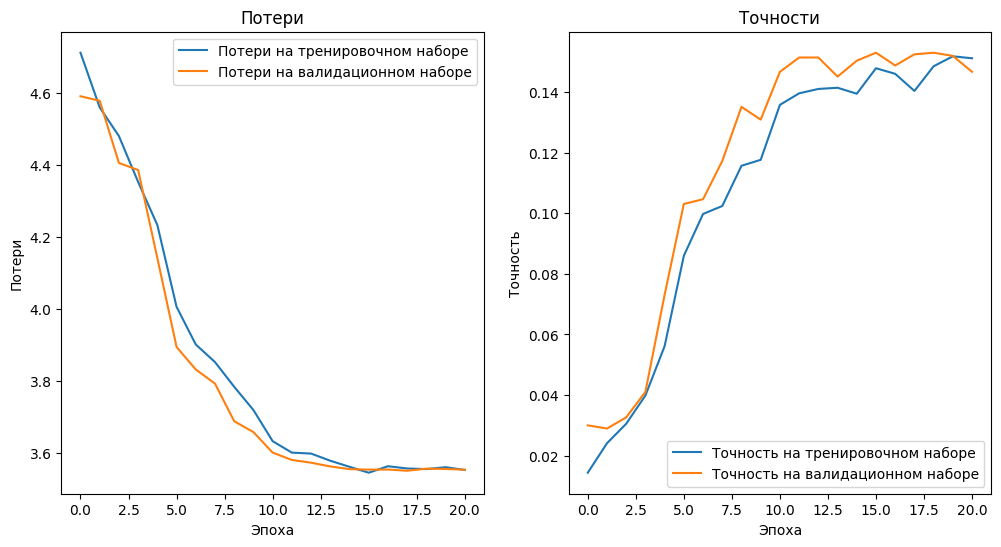

Лучшая модель сохранена.


In [5]:

import albumentations as A
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image

data_directory = '/kaggle/input/dl-2025-competition-1/data/train'

train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(width=32, height=32, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(),
])

val_augmentation = A.Compose([
    A.Normalize(),
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, augmentations=None):
        self.dataset = dataset
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if isinstance(image, Image.Image):
            image = np.array(image)
        if self.augmentations:
            image = self.augmentations(image=image)["image"]
        if isinstance(image, np.ndarray):
            if image.dtype == np.float32 or image.dtype == np.float64:
                image = (image * 255).astype(np.uint8)
        
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)
        return image, label

image_transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=data_directory)


class_counts = np.bincount([y for _, y in full_dataset.samples])
total_samples = len(full_dataset)


class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.FloatTensor(class_weights).to(device) 


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(CustomDataset(train_dataset, transform=image_transformations, augmentations=train_augmentation), 
                          batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(CustomDataset(val_dataset, transform=image_transformations, augmentations=val_augmentation), 
                        batch_size=32, shuffle=False, num_workers=4)

model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_dataset.classes))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 30
best_loss = float('inf')
early_stopping_counter = 0
patience = 3
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)
        loss = loss_function(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(predictions.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = loss_function(predictions, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_accuracy = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Ранняя остановка активирована.")
            break

    scheduler.step()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Потери на тренировочном наборе')
plt.plot(val_losses, label='Потери на валидационном наборе')
plt.title('Потери')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Точность на тренировочном наборе')
plt.plot(val_accuracies, label='Точность на валидационном наборе')
plt.title('Точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.show()

print("Лучшая модель сохранена.")

Уникальные метки: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Epoch [1/30]
Train Loss: 4.5986, Accuracy: 0.0263
Val Loss: 4.4430, Accuracy: 0.0400

Epoch [2/30]
Train Loss: 4.3151, Accuracy: 0.0672
Val Loss: 4.2107, Accuracy: 0.0931

Epoch [3/30]
Train Loss: 4.0969, Accuracy: 0.1308
Val Loss: 4.0194, Accuracy: 0.1404

Epoch [4/30]
Train Loss: 3.8872, Accuracy: 0.1983
Val Loss: 3.8323, Accuracy: 0.1935

Epoch [5/30]
Train Loss: 3.7072, Accuracy: 0.2415
Val Loss: 3.6763, Accuracy: 0.2292

Epoch [6/30]
Train Loss: 3.5333, Accuracy: 0.2890
Val Loss: 3.5239, Accuracy: 0.2650

Epoch [7/30]
Train Loss: 3.3811, Accuracy: 0.3195
Val Loss: 3.3939, Accuracy: 0.2918

Epoch [8/30]
Train Loss: 3.2529, Accuracy: 0.3524
Val Loss: 3.2896, Accura

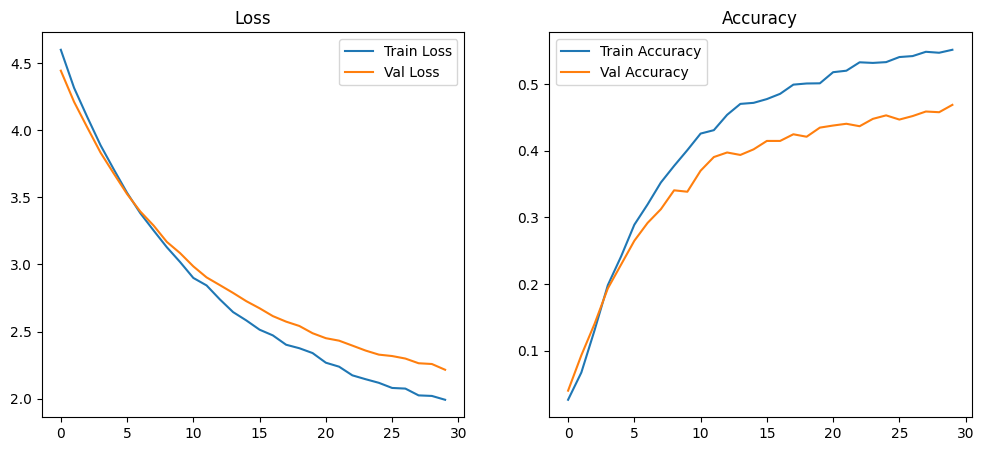

Best Validation Accuracy: 0.4690


In [97]:
data_directory = '/kaggle/input/dl-2025-competition-1/data/train'


train_augmentation = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_augmentation = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augmentations=None):
        self.dataset = dataset
        self.augmentations = augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)
        
        if self.augmentations:
            image = self.augmentations(image=image)["image"]
        
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
        return image, label


full_dataset = datasets.ImageFolder(root=data_directory)
train_size = int(0.8 * len(full_dataset))
train_dataset, val_dataset = random_split(full_dataset, [train_size, len(full_dataset) - train_size])





train_labels = [label for _, label in train_dataset]
class_counts = np.bincount(train_labels)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


train_loader = DataLoader(
    CustomDataset(train_dataset, augmentations=train_augmentation),
    batch_size=64,
    sampler=sampler,
    num_workers=4
)

val_loader = DataLoader(
    CustomDataset(val_dataset, augmentations=val_augmentation),
    batch_size=64,
    shuffle=False,
    num_workers=4
)


model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_dataset.classes))


for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()


num_epochs = 30
best_val_accuracy = 0.0
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

   
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}\n')


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')

/tmp/ipykernel_31/3515223412.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))


Сопоставление классов:
0 -> 0
1 -> 1
2 -> 10
3 -> 11
4 -> 12
5 -> 13
6 -> 14
7 -> 15
8 -> 16
9 -> 17
10 -> 18
11 -> 19
12 -> 2
13 -> 20
14 -> 21
15 -> 22
16 -> 23
17 -> 24
18 -> 25
19 -> 26
20 -> 27
21 -> 28
22 -> 29
23 -> 3
24 -> 30
25 -> 31
26 -> 32
27 -> 33
28 -> 34
29 -> 35
30 -> 36
31 -> 37
32 -> 38
33 -> 39
34 -> 4
35 -> 40
36 -> 41
37 -> 42
38 -> 43
39 -> 44
40 -> 45
41 -> 46
42 -> 47
43 -> 48
44 -> 49
45 -> 5
46 -> 50
47 -> 51
48 -> 52
49 -> 53
50 -> 54
51 -> 55
52 -> 56
53 -> 57
54 -> 58
55 -> 59
56 -> 6
57 -> 60
58 -> 61
59 -> 62
60 -> 63
61 -> 64
62 -> 65
63 -> 66
64 -> 67
65 -> 68
66 -> 69
67 -> 7
68 -> 70
69 -> 71
70 -> 72
71 -> 73
72 -> 74
73 -> 75
74 -> 76
75 -> 77
76 -> 78
77 -> 79
78 -> 8
79 -> 80
80 -> 81
81 -> 82
82 -> 83
83 -> 84
84 -> 85
85 -> 86
86 -> 87
87 -> 88
88 -> 89
89 -> 9
90 -> 90
91 -> 91
92 -> 92
93 -> 93
94 -> 94
95 -> 95
96 -> 96
97 -> 97
98 -> 98
99 -> 99
0.png -> 71
1.png -> 62
2.png -> 18
3.png -> 41
4.png -> 66
5.png -> 86
6.png -> 11
7.png -> 38
8

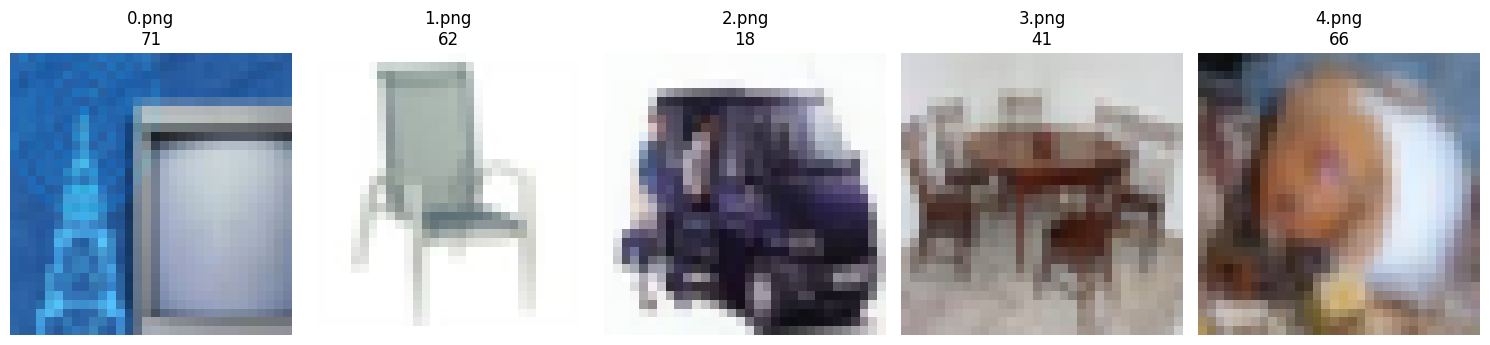

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_dataset.classes))  # Используем то же количество классов
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model = model.to(device)
model.eval()


data_directory = '/kaggle/input/dl-2025-competition-1/data/train'
full_dataset = datasets.ImageFolder(root=data_directory)


classes = full_dataset.classes
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

print("Сопоставление классов:")
for idx, name in idx_to_class.items():
    #print(f"{idx} -> {name}")


test_augmentation = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    
    augmented = test_augmentation(image=image)
    image_tensor = torch.from_numpy(augmented["image"].transpose(2, 0, 1)).float().unsqueeze(0).to(device)
    
    # Предсказание
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs.data, 1)
    
    return idx_to_class[predicted_idx.item()] 


test_data_directory = '/kaggle/input/dl-2025-competition-1/data/test'
test_image_files = [f for f in os.listdir(test_data_directory) if f.endswith(('.png'))]


test_image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))


predictions = {}
for img_file in test_image_files:
    img_path = os.path.join(test_data_directory, img_file)
    class_name = predict_image(img_path)
    predictions[img_file] = class_name
    #print(f"{img_file} -> {class_name}")


with open('submission.csv', 'w') as f:
    f.write("image,class\n")
    for img_file in test_image_files:
        f.write(f"{img_file},{predictions[img_file]}\n")

print("Предсказания сохранены в submission.csv")


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, img_file in enumerate(test_image_files[:5]):
    img_path = os.path.join(test_data_directory, img_file)
    img = Image.open(img_path)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{img_file}\n{predictions[img_file]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Epoch 1/30
Train Loss: 4.4125 | Acc: 0.0342
Val Loss: 4.0990 | Acc: 0.0768

Epoch 2/30
Train Loss: 4.0286 | Acc: 0.0783
Val Loss: 3.8196 | Acc: 0.1020

Epoch 3/30
Train Loss: 3.7691 | Acc: 0.1182
Val Loss: 3.6048 | Acc: 0.1519

Epoch 4/30
Train Loss: 3.4787 | Acc: 0.1696
Val Loss: 3.4262 | Acc: 0.1914

Epoch 5/30
Train Loss: 2.9697 | Acc: 0.2710
Val Loss: 3.3521 | Acc: 0.2166

Epoch 6/30
Train Loss: 2.2814 | Acc: 0.4172
Val Loss: 3.4217 | Acc: 0.2245

Epoch 7/30
Train Loss: 1.5992 | Acc: 0.5722
Val Loss: 3.8781 | Acc: 0.2050

Epoch 8/30
Train Loss: 1.1311 | Acc: 0.6877
Val Loss: 4.0954 | Acc: 0.2161

Epoch 9/30
Train Loss: 0.8315 | Acc: 0.7688
Val Loss: 4.4642 | Acc: 0.2161

Epoch 10/30
Train Loss: 0.6137 | Acc: 0.8236
Val Loss: 4.9245 | Acc: 0.2098

Epoch 11/30
Train Loss: 0.5029 | Acc: 0.8550
Val Loss: 4.9863 | Acc: 0.2040

Epoch 12/30
Train Loss: 0.4195 | Acc: 0.8764
Val Loss: 5.1788 | Acc: 0.2045

Epoch 13/30
Train Loss: 0.3672 | Acc: 0.8952
Val Loss: 5.4513 | Acc: 0.1966

Epoch 14

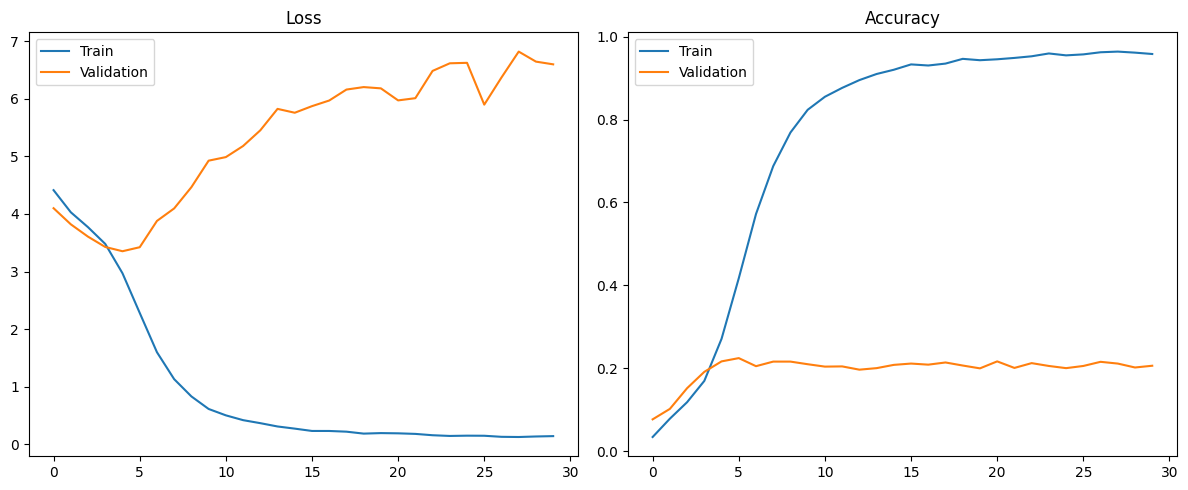

Best Validation Accuracy: 0.2245


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


class TrainingConfig:
    def __init__(self):
        self.batch_size = 64
        self.learning_rate = 0.001
        self.epochs = 30
        self.train_ratio = 0.8
        self.image_size = 224


class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


def prepare_datasets(data_path):
    train_transforms = transforms.Compose([
        transforms.Resize(config.image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(data_path, transform=train_transforms)
    train_size = int(len(full_dataset) * config.train_ratio)
    val_size = len(full_dataset) - train_size
    
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transforms
    
    return train_dataset, val_dataset, full_dataset.classes


def train_model(model, train_loader, val_loader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    best_accuracy = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)

        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch+1}/{config.epochs}')
        print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n')
    
    return history, best_accuracy


def plot_results(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    config = TrainingConfig()
    data_path = '/kaggle/input/dl-2025-competition-1/data/train'
    
    train_dataset, val_dataset, classes = prepare_datasets(data_path)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size)
    
    model = ImageClassifier(len(classes))
    history, best_acc = train_model(model, train_loader, val_loader, len(classes))
    
    plot_results(history)
    print(f'Best Validation Accuracy: {best_acc:.4f}')

Выше модель без transfer learning и без навороченных аугментаций, акьюраси теперь ниже чем у модели с навороченными, она быстро переобучается, и поэтому на тестовой выборке может быть такой низкий акьюарси

In [10]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

if __name__ == "__main__":
    
    config = TrainingConfig()
    data_path = '/kaggle/input/dl-2025-competition-1/data/train'
    test_data_directory = '/kaggle/input/dl-2025-competition-1/data/test'
    

    
    print("Starting prediction on test images...")
    
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    
    test_transform = transforms.Compose([
        transforms.Resize(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    
    test_image_files = [f for f in os.listdir(test_data_directory) if f.endswith('.png')]
    test_image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    
    
    with open('submission.csv', 'w') as f:
        f.write('image,class\n')
        
        for img_file in test_image_files:
            try:
                img_path = os.path.join(test_data_directory, img_file)
                image = Image.open(img_path).convert('RGB')
                image = test_transform(image).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    output = model(image)
                    probabilities = F.softmax(output, dim=1)
                    _, predicted_idx = torch.max(output, 1)
                    predicted_class = idx_to_class[predicted_idx.item()]
                
                f.write(f'{img_file},{predicted_class}\n')
                
            
            except Exception as e:
                print(f'Error processing {img_file}: {str(e)}')
                continue
    
    print("\nPrediction completed. Results saved to submission.csv")

Starting prediction on test images...


/tmp/ipykernel_31/978280006.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Prediction completed. Results saved to submission.csv


In [28]:
test = pd.read_csv('/kaggle/input/dl-2025-competition-1/sample_submission.csv')
test_not =  pd.read_csv('/kaggle/working/submission.csv')
test['target'] = test_not['class']

Здесь я открываю файл csv, который предсказался и был мною загружен, теперь я просто перемещаю в самбишн сэмпл мои классы. Картинки для примера показывают, что модель работает корректно, все классы оказались такими же по смыслу, как в трейне, т.е. у меня есть модель ниже которая выбила скор 0.6, я предсказываю и возвращаюсб в этот блок обновляю и в csv

In [29]:
test.to_csv('sample.csv', index=False)

попробую модель которая повысит скор

сохраняю файл тест как сэмпл чтобы не запутаться, и его подгружаю уже в кагл для сабмишна

Epoch 1/30
Train Loss: 4.3762 | Acc: 0.0681
Val Loss: 3.4978 | Acc: 0.2487
--------------------------------------------------
Epoch 2/30
Train Loss: 3.3791 | Acc: 0.2321
Val Loss: 2.6599 | Acc: 0.3859
--------------------------------------------------
Epoch 3/30
Train Loss: 2.7386 | Acc: 0.3611
Val Loss: 2.2568 | Acc: 0.4837
--------------------------------------------------
Epoch 4/30
Train Loss: 2.3731 | Acc: 0.4385
Val Loss: 2.0049 | Acc: 0.5315
--------------------------------------------------
Epoch 5/30
Train Loss: 2.0980 | Acc: 0.4968
Val Loss: 1.8120 | Acc: 0.5736
--------------------------------------------------
Epoch 6/30
Train Loss: 1.8818 | Acc: 0.5473
Val Loss: 1.6756 | Acc: 0.5883
--------------------------------------------------
Epoch 7/30
Train Loss: 1.6505 | Acc: 0.5954
Val Loss: 1.5819 | Acc: 0.6099
--------------------------------------------------
Epoch 8/30
Train Loss: 1.5162 | Acc: 0.6364
Val Loss: 1.5088 | Acc: 0.6225
-------------------------------------------

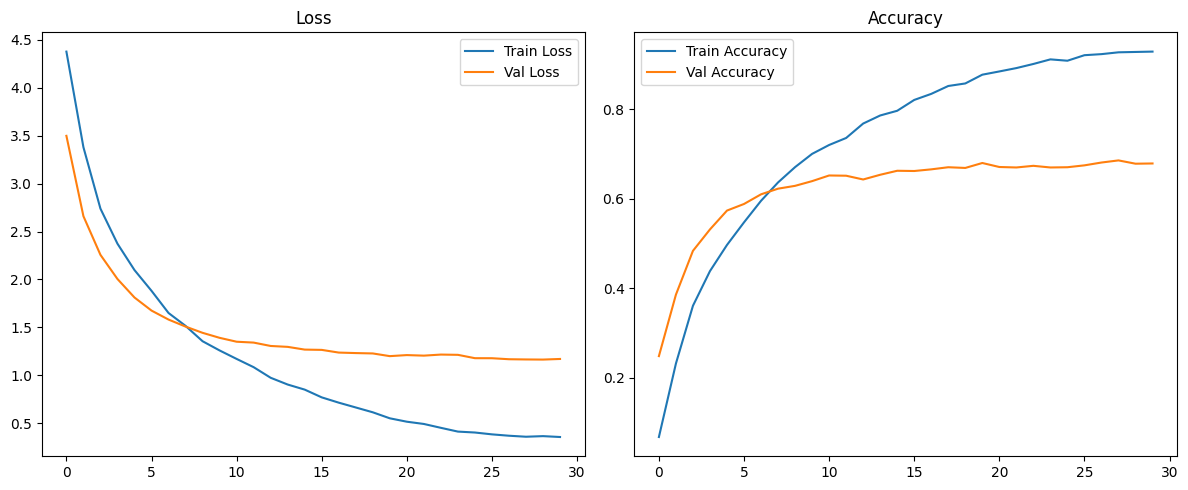

Best Validation Accuracy: 0.6856


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

DATA_DIR = '/kaggle/input/dl-2025-competition-1/data/train'
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_WORKERS = 4


train_transform = A.Compose([
    A.Resize(IMG_SIZE + 32, IMG_SIZE + 32),
    A.RandomCrop(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

def create_data_loaders():

    full_dataset = datasets.ImageFolder(root=DATA_DIR)
    
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42))
    
   
    train_labels = [label for _, label in train_dataset]
    class_counts = np.bincount(train_labels)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[train_labels]
    sampler = WeightedRandomSampler(
        sample_weights, len(sample_weights), replacement=True)
    
    train_ds = AlbumentationsDataset(train_dataset, train_transform)
    val_ds = AlbumentationsDataset(val_dataset, val_transform)
    

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    return train_loader, val_loader, full_dataset.classes

def initialize_model(num_classes):
    model = torchvision.models.resnet18(pretrained=True)
    

    for param in model.parameters():
        param.requires_grad = False
    
    
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes)
    )
    

    for param in model.layer4.parameters():
        param.requires_grad = True
    
    return model

def train_model(model, train_loader, val_loader, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.1)
    criterion = nn.CrossEntropyLoss()
    
    best_val_accuracy = 0.0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(NUM_EPOCHS):
    
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
      
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        

        scheduler.step(val_acc)
        

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}')
        print('-' * 50)
    
    return history, best_val_accuracy

def plot_results(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
   
    train_loader, val_loader, classes = create_data_loaders()
    model = initialize_model(len(classes))
    
    
    history, best_acc = train_model(model, train_loader, val_loader, len(classes))
    
    
    plot_results(history)
    print(f'Best Validation Accuracy: {best_acc:.4f}')

if __name__ == '__main__':
    main()

/tmp/ipykernel_31/1143829607.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=device))


Предсказания сохранены в submission.csv


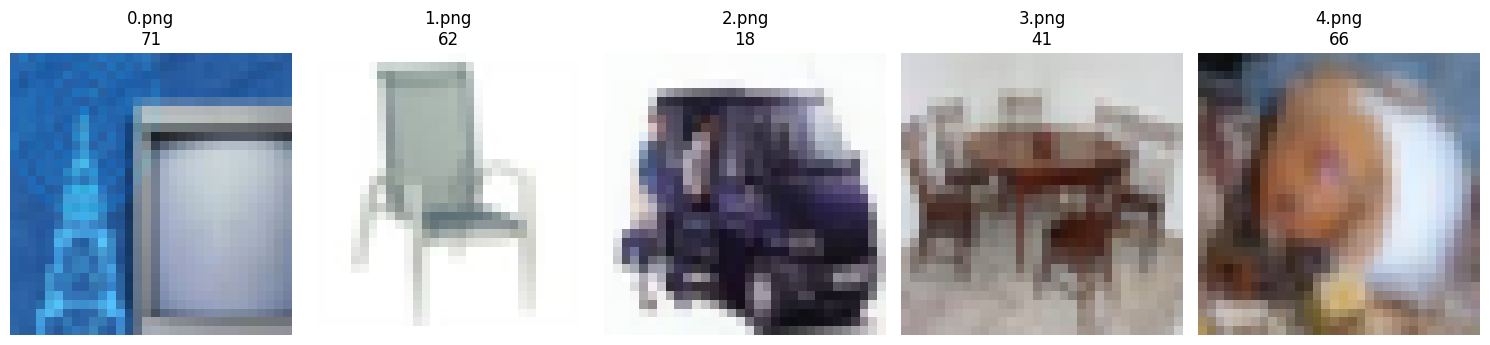

In [27]:
def predict():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    

    model = torchvision.models.resnet18(pretrained=True)

    full_dataset = datasets.ImageFolder(root=DATA_DIR)
    classes = full_dataset.classes
    num_classes = len(classes)
    

    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, num_classes))
    

    for param in model.layer4.parameters():
        param.requires_grad = True
    

    try:
        model.load_state_dict(torch.load('best_model.pth', map_location=device))
    except RuntimeError as e:
        print(f"Ошибка загрузки весов: {e}")
        print("Проверьте, что структура модели соответствует сохраненным весам")
        return
    
    model = model.to(device)
    model.eval()
    

    idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}
    
    test_transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    def predict_image(image_path):
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
        
        augmented = test_transform(image=image)
        image_tensor = augmented["image"].unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted_idx = torch.max(outputs.data, 1)
        
        return idx_to_class[predicted_idx.item()]
    
    test_data_directory = '/kaggle/input/dl-2025-competition-1/data/test'
    test_image_files = [f for f in os.listdir(test_data_directory) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    test_image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    
    predictions = {}
    for img_file in test_image_files:
        img_path = os.path.join(test_data_directory, img_file)
        predictions[img_file] = predict_image(img_path)
    
    with open('submission.csv', 'w') as f:
        f.write("image,class\n")
        for img_file in test_image_files:
            f.write(f"{img_file},{predictions[img_file]}\n")
    
    print("Предсказания сохранены в submission.csv")
    
    plt.figure(figsize=(15, 10))
    for i, img_file in enumerate(test_image_files[:5]):
        img_path = os.path.join(test_data_directory, img_file)
        img = Image.open(img_path)
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{img_file}\n{predictions[img_file]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    predict()

генератор

Using GPU: Tesla T4
Loaded dataset with 100 classes
Starting training...
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed


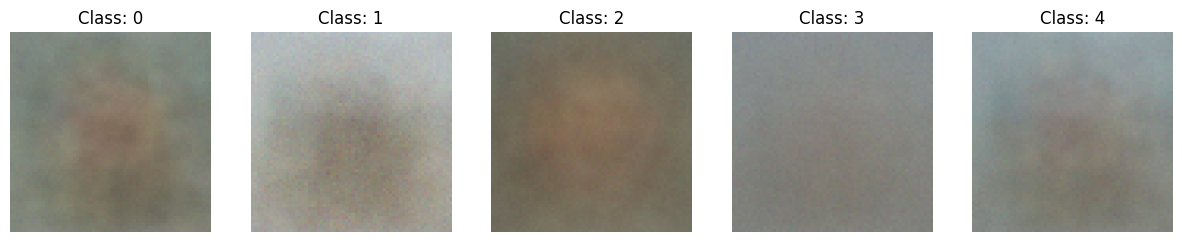

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os


def setup_environment():
  
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    
    if not torch.cuda.is_available():
        return torch.device('cpu')
    
    device = torch.device('cuda')
    try:
      
        _ = torch.tensor([1.0]).to(device)
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        return device
    except RuntimeError as e:
        print(f"CUDA initialization failed: {e}")
        return torch.device('cpu')


class SafeGenerator(nn.Module):
    def __init__(self, num_classes, latent_dim=100):
        super().__init__()
        self.num_classes = num_classes
        
        if num_classes <= 0:
            raise ValueError("num_classes must be positive")
            
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 3*64*64),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        
        if noise.dim() != 2 or noise.size(1) != 100:
            raise ValueError("Invalid noise shape")
        if (labels >= self.num_classes).any() or (labels < 0).any():
            raise ValueError("Invalid class labels")
            
        gen_input = self.label_emb(labels) * noise
        output = self.model(gen_input)
        return output.view(-1, 3, 64, 64)


def load_data_safely(data_dir):
    try:
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        dataset = datasets.ImageFolder(data_dir, transform=transform)
        
        # Проверка классов
        for _, label in dataset:
            if not isinstance(label, int) or label < 0:
                raise ValueError(f"Invalid label: {label}")
                
        num_classes = len(dataset.classes)
        print(f"Loaded dataset with {num_classes} classes")
        
        return DataLoader(dataset, batch_size=64, shuffle=True), num_classes
        
    except Exception as e:
        print(f"Data loading error: {e}")
        raise


def train_generator_safely(generator, dataloader, device):
    generator.to(device)
    optimizer = optim.Adam(generator.parameters(), lr=0.0002)
    criterion = nn.MSELoss()
    
    for epoch in range(30):
        for batch_idx, (real_imgs, real_labels) in enumerate(dataloader):
            try:
                
                if real_imgs.size(0) == 0:
                    continue
                    
                real_imgs = real_imgs.to(device)
                real_labels = real_labels.to(device)
                
                
                noise = torch.randn(real_imgs.size(0), 100, device=device)
                gen_imgs = generator(noise, real_labels)
                
           
                loss = criterion(gen_imgs, real_imgs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
                
        print(f"Epoch {epoch+1} completed")


def main():
    try:
        device = setup_environment()
        DATA_DIR = '/kaggle/input/dl-2025-competition-1/data/train'
        

        dataloader, num_classes = load_data_safely(DATA_DIR)
        

        generator = SafeGenerator(num_classes)
        

        print("Starting training...")
        train_generator_safely(generator, dataloader, device)
        

        generator.eval()
        with torch.no_grad():
            noise = torch.randn(5, 100, device=device)
            labels = torch.arange(5, device=device) % num_classes
            images = generator(noise, labels).cpu()
            

            plt.figure(figsize=(15, 5))
            for i in range(5):
                img = images[i].permute(1, 2, 0).numpy()
                img = (img + 1) / 2  # Денормализация
                plt.subplot(1, 5, i+1)
                plt.imshow(np.clip(img, 0, 1))
                plt.title(f"Class: {labels[i].item()}")
                plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"Program failed: {e}")
    finally:
        if torch.cuda.is_initialized():
            torch.cuda.empty_cache()

if __name__ == "__main__":
    main()